## 0. Goal

#### Heart Arrhythmia Detection from ECG waveform with Deep Learning model

----

## 1. Backgrounds

##### - datasest: MIT-BIH Arrhythmia dataset을 활용 (source: https://physionet.org/content/mitdb/1.0.0/)

------

## 2. Data distribution and Basic Statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import os
import sys
import glob
import tqdm
import random
from itertools import cycle
import warnings
warnings.filterwarnings(action='ignore')

import wfdb

from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc
from sklearn.preprocessing import label_binarize

In [3]:
# datapath
datapath = r'c:/users/MI2RL-KHJ/workspace_signal/physionet_raw/mit-bih-arrhythmia-database-1.0.0'
# mimic dataset 파일 구성: hea, atr, dat, xws
print(os.listdir(datapath))

['100.atr', '100.dat', '100.hea', '100.xws', '101.atr', '101.dat', '101.hea', '101.xws', '102-0.atr', '102.atr', '102.dat', '102.hea', '102.xws', '103.atr', '103.dat', '103.hea', '103.xws', '104.atr', '104.dat', '104.hea', '104.xws', '105.atr', '105.dat', '105.hea', '105.xws', '106.atr', '106.dat', '106.hea', '106.xws', '107.atr', '107.dat', '107.hea', '107.xws', '108.atr', '108.at_', '108.dat', '108.hea', '108.xws', '109.atr', '109.dat', '109.hea', '109.xws', '111.atr', '111.dat', '111.hea', '111.xws', '112.atr', '112.dat', '112.hea', '112.xws', '113.atr', '113.dat', '113.hea', '113.xws', '114.atr', '114.dat', '114.hea', '114.xws', '115.atr', '115.dat', '115.hea', '115.xws', '116.atr', '116.dat', '116.hea', '116.xws', '117.atr', '117.at_', '117.dat', '117.hea', '117.xws', '118.atr', '118.dat', '118.hea', '118.xws', '119.atr', '119.at_', '119.dat', '119.hea', '119.xws', '121.atr', '121.dat', '121.hea', '121.xws', '122.atr', '122.dat', '122.hea', '122.xws', '123.atr', '123.dat', '123.he

In [4]:
header_files = [os.path.basename(x) for x in glob.glob(os.path.join(datapath, '*.hea'))]
pids = sorted([x.split('.')[0] for x in header_files])

In [5]:
# annotation 파일 불러와서 label의 분포 확인
df = pd.DataFrame()

for pid in pids:
    file = os.path.join(datapath, pid)
    annotation = wfdb.rdann(os.path.join(file), 'atr')
    symbols = annotation.symbol
    
    values, cnts = np.unique(symbols, return_counts=True)
    df_sub = pd.DataFrame({'symbol': values, 'value': cnts, 'pid':[pid] * len(cnts)})
    df = pd.concat([df, df_sub], axis=0)

In [6]:
# Annotation 파일의 분포
df.groupby('symbol').value.sum().sort_values(ascending = False)

symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: value, dtype: int64

In [7]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [8]:
# normal, abnormal, nonbeat의 비율 구성 확인
df['type'] = -1 # nonbeat
df.loc[df.symbol == 'N', 'type'] = 0 # normal
df.loc[df.symbol.isin(abnormal), 'type'] = 1 # abnormal

In [9]:
df['type2'] = 'Non-beat' # nonbeat
df.loc[df.symbol == 'N', 'type2'] = 'Normal' # normal
df.loc[df.symbol.isin(abnormal), 'type2'] = 'Abnormal' # abnormal

In [10]:
df.groupby('type2').value.sum()

type2
Abnormal    34409
Non-beat     3186
Normal      75052
Name: value, dtype: int64

#### Define ECG data loading function

In [14]:
# load single patient's ecg signal and annotation
def load_ecg(file):
    """
    wfdb.rdrecord 를 이용해서 ecg 파일을 읽어옵니다.
    """
    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_index = annotation.sample
    
    return p_signal, atr_sym, atr_index

# p_signal = raw ecg signal
# atr_sym = annotation symbol
# atr_sample = annotation index

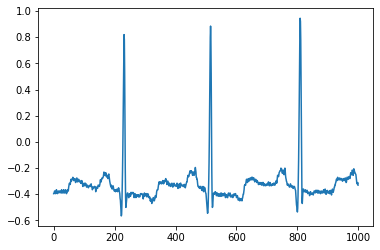

In [15]:
file = os.path.join(datapath, pids[0])
p_signal, atr_sym, atr_sample = load_ecg(file)
plt.plot(p_signal[1000:2000, 0])

In [16]:
values, counts = np.unique(atr_sym, return_counts = True)
for v, c in zip(values, counts):
    print(v, c)

+ 1
A 33
N 2239
V 1


In [17]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

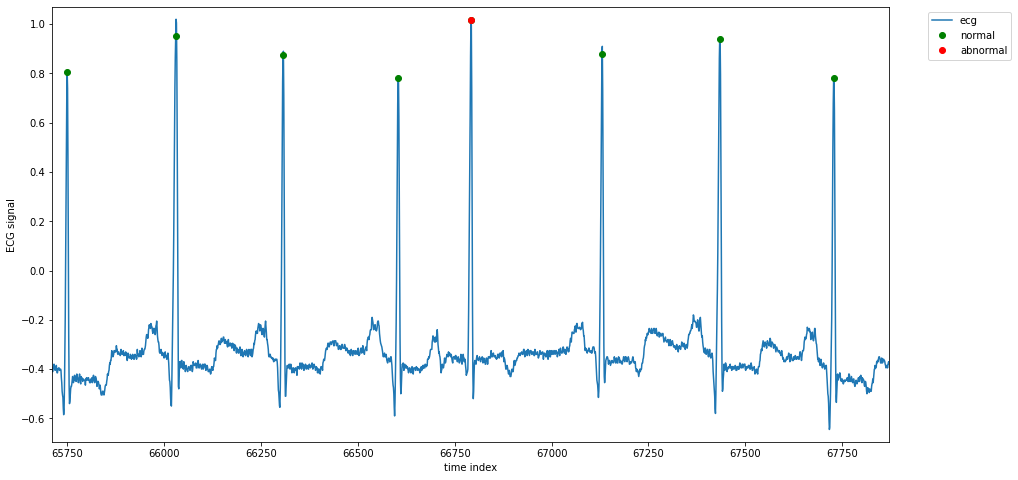

In [18]:
# abnormal에 해당되는 annotation의 index를 기준으로, 전후 3초의 ecg signal을 plotting
x = np.arange(len(p_signal))
left = ab_index[1]-(360*3) # 전 3초
right = ab_index[1]+(360*3) # 후 3초

plt.figure(figsize=(15, 8))
plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

---------------

## 3. Preparing dataset for deep learning

#### 3-1. Define functions to build dataset for deep learning

In [24]:
def build_dataset(pids, window_size, freq, abnormal):
    """
    딥러닝 모델 학습을 위한 데이터를 구축합니다.
    """
    ncols = window_size * freq
    X_merged = np.zeros((1, ncols))
    Y_merged = np.zeros((1,1))
    symbol_merged = []
    
    rows_per_pid = []
    
    for pid in tqdm.tqdm(pids):
        
        filename = os.path.join(datapath, pid)
        p_signal, atr_sym, atr_sample = load_ecg(filename)
        
        p_signal = p_signal[:,0]
        
        # beat index (exclude non-beat)
        beat_annotation_index = [x in (abnormal + ['N']) for x in atr_sym]
        
        X, Y, symbols = build_XY(signal=p_signal, 
                                 atr_sym = atr_sym, 
                                 atr_sample = atr_sample,
                                 beat_index = beat_annotation_index, 
                                 nsec = window_size/2, 
                                 fs = freq,
                                 ncols = ncols,
                                 abnormal = abnormal)
        
        X_merged = np.append(X_merged, X, axis=0)
        Y_merged = np.append(Y_merged, Y, axis=0)
        symbol_merged = symbol_merged + symbols
        rows_per_pid.append(Y.shape[0])
        
    # drop first zero rows
    X_merged = X_merged[1:,:]
    Y_merged = Y_merged[1:,:]
    
    # check sizes make sense
    assert np.sum(rows_per_pid) == X_merged.shape[0], 'number of X, max_rows rows messed up'
    assert Y_merged.shape[0] == X_merged.shape[0], 'number of X, Y rows messed up'
    assert Y_merged.shape[0] == len(symbol_merged), 'number of Y, sym rows messed up'
    
    return X_merged, Y_merged, symbol_merged


def build_XY(signal, atr_sym, atr_sample, beat_index, nsec, fs, ncols, abnormal):
    """
    하나의 환자 id에서 signal과 annotation을 추출합니다.
    """
    
    num_rows = len(beat_index)

    X = np.zeros((num_rows, ncols))
    Y = np.zeros((num_rows,1))
    symbols = []
    
    # keep track of rows
    max_row = 0
    
    beat_atr_sym = np.array(atr_sym)[beat_index]
    beat_atr_sample = np.array(atr_sample)[beat_index]

    for sym, samp in zip(beat_atr_sym, beat_atr_sample):

        left = int(max([0,(samp - nsec*fs) ]))
        right = int(min([len(signal),(samp + nsec*fs) ]))
        
        x = signal[left: right]
        if len(x) == ncols:
            X[max_row,:] = x
            Y[max_row,:] = int(sym in abnormal)
            symbols.append(sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X, Y, symbols

#### 3-2. Build train and validation dataset

In [21]:
# 6초의 segment로 데이터 구축
window_size = 6
frequency = 360
batch_size = 1000

In [22]:
# dataset split
random.seed(77)
pids_test = random.sample(pids, int(len(pids) / 4))
pids_train = [pid for pid in pids if pid not in pids_test]

In [25]:
# build dataset
X_train, Y_train, symbol_train = build_dataset(pids_train, 
                                               window_size, 
                                               frequency, 
                                               abnormal)
X_test, Y_test, symbol_test = build_dataset(pids_test,
                                              window_size,
                                              frequency,
                                              abnormal)

print("Shape of train dataset: \n X: {} \n Y: {} \n symbol: {} \n".format(
X_train.shape, Y_train.shape, len(symbol_train)))
print("Shape of test dataset: \n X: {} \n Y: {} \n symbol: {} \n".format(
X_test.shape, Y_test.shape, len(symbol_test)))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.57it/s]

Shape of train dataset: 
 X: (82168, 2160) 
 Y: (82168, 1) 
 symbol: 82168 

Shape of test dataset: 
 X: (26931, 2160) 
 Y: (26931, 1) 
 symbol: 26931 



In [26]:
# train / test set symbol 확인
print(np.unique(symbol_train))
print(np.unique(symbol_test))

['/' 'A' 'E' 'F' 'J' 'L' 'N' 'R' 'S' 'V' 'a' 'e' 'f' 'j']
['/' 'A' 'F' 'L' 'N' 'R' 'V' 'a' 'j']


In [27]:
# train과 test set의 abnormal 비율 확인
print('{:.3f} %'.format((Y_train.sum() / len(Y_train))* 100))
print('{:.3f} %'.format((Y_test.sum() / len(Y_test))* 100))

30.569 %
34.109 %


---------

## 4. Deep Learning model training - binary classification

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras import optimizers

Using TensorFlow backend.


#### 4-1. Define Fully Connected Network

In [29]:
fcn_model = Sequential()
fcn_model.add(Dense(512, activation = 'relu'))
fcn_model.add(Dropout(rate=0.25))
fcn_model.add(Dense(128, activation = 'relu'))
fcn_model.add(Dropout(rate=0.25))
fcn_model.add(Dense(1, activation='sigmoid'))

adam_optimizer = optimizers.Adam(lr=0.00005)
fcn_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

#### 4-2. Model fitting

In [31]:
fcn_train_history = fcn_model.fit(X_train, Y_train, epochs=10, batch_size = batch_size, verbose=1,
                         validation_split = 0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 65734 samples, validate on 16434 samples
Epoch 1/10
65734/65734 [==============================] - 3s 49us/step - loss: 0.5596 - accuracy: 0.7277 - val_loss: 0.3947 - val_accuracy: 0.8576
Epoch 2/10
65734/65734 [==============================] - 3s 47us/step - loss: 0.4052 - accuracy: 0.8339 - val_loss: 0.3406 - val_accuracy: 0.8724
Epoch 3/10
65734/65734 [==============================] - 3s 48us/step - loss: 0.3364 - accuracy: 0.8714 - val_loss: 0.3075 - val_accuracy: 0.8826
Epoch 4/10
65734/65734 [==============================] - 3s 50us/step - loss: 0.2878 - accuracy: 0.8953 - val_loss: 0.2760 - val_accuracy: 0.8990
Epoch 5/10
65734/65734 [==============================] - 3s 50us/step - loss: 0.2509 - accuracy: 0.9099 - val_loss: 0.2555 - val_accuracy: 0.907515 - accuracy: 0.90
Epoch 6/10
65734/65734 [==============================] - 3s 50us/step - loss: 0.2170 - accuracy: 0.9

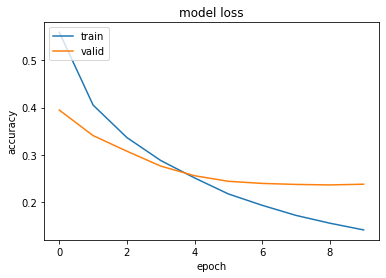

In [33]:
plt.plot(fcn_train_history.history['loss'])
plt.plot(fcn_train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

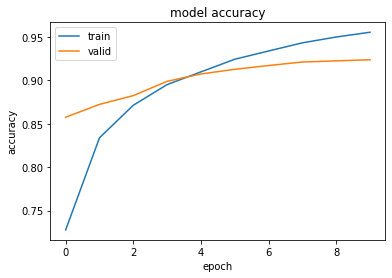

In [32]:
plt.plot(fcn_train_history.history['accuracy'])
plt.plot(fcn_train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

#### 4-4. Result

In [34]:
fcn_result = fcn_model.predict_classes(X_test)

In [35]:
print(classification_report(Y_test, fcn_result, target_names=['normal', 'abnormal']))

              precision    recall  f1-score   support

      normal       0.78      0.98      0.86     17745
    abnormal       0.91      0.45      0.60      9186

    accuracy                           0.80     26931
   macro avg       0.84      0.71      0.73     26931
weighted avg       0.82      0.80      0.78     26931

